<a href="https://colab.research.google.com/github/Leejw221/Reinforcement_learning_study/blob/main/DINOv2/Train_a_linear_classifier_on_top_of_DINOv2_for_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear probing of DINOv2 for semantic segmentation

In this notebook, we're going to train a linear classifier on top of a frozen [DINOv2](https://huggingface.co/docs/transformers/main/model_doc/dinov2) backbone for semantic segmentation (the task of predicting a semantic category for every pixel in an image). DINOv2 is a vision transformer trained in a self-supervised fashion on a highly curated dataset of 142 million images. At the time of writing, it provides one of the best **image features** (i.e. embeddings) which one can use for downstream tasks such as image classification, image segmentation and depth estimation. This makes DINOv2 one of the best **backbones** (i.e. the first building block you typically use in your pipeline) for computer vision tasks nowadays.

In their paper, the authors show that a decoder head as simple as a linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) on top of it already beats existing state-of-the-art methods. Of course, using heavier, more complex decoder heads leads to even better performance. For instance, if you add a [Mask2Former](https://huggingface.co/docs/transformers/main/model_doc/mask2former) decoder head on top of DINOv2 as backbone for semantic segmentation, you get even better performance.

The figure below illustrates the idea; we're just going to train a linear transformation on top of a frozen DINOv2 backbone, which will convert the features (patch embeddings) to the logits (the unnormalized scores which neural networks output, indicating the model's predictions). In case of semantic segmentation, the logits will be of shape (batch_size, num_classes, height, width), as one predicts a class per pixel.

<img src="https://huggingface.co/datasets/nielsr/sample-images/resolve/main/dinov2_linear_classifier_bis.png"
alt="drawing" width="300"/>

* DINOv2 docs: https://huggingface.co/docs/transformers/main/model_doc/dinov2.

* DINOv2 blog post: https://dinov2.metademolab.com/.

Special thank you to the people in [this Github thread](https://github.com/facebookresearch/dinov2/issues/25) which inspired me to create this tutorial.


## Set-up environment

Let's start by installing our favorite libraries: 🤗 Transformers and 🤗 Datasets. We install Transformers from source since the model is brand new at the time of writing.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We'll also use 🤗 Evaluate to calculate metrics.

In [2]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


## Load dataset

Next, let's load an image segmentation dataset. In this case, we'll use the [FoodSeg](https://huggingface.co/datasets/EduardoPacheco/FoodSeg103) dataset.

Want to use your own custom dataset? [Here](https://github.com/huggingface/transformers/tree/main/examples/pytorch/semantic-segmentation#note-on-custom-data)'s a guide regarding turning it into a 🤗 dataset (and you could potentially upload it to the hub as a public/private repo).

In [1]:
# 한 번에 모든 문제 해결
!pip install fsspec==2023.9.2
!pip install -U datasets
!rm -rf ~/.cache/huggingface/datasets/

# 런타임 재시작 후
from datasets import load_dataset
dataset = load_dataset("EduardoPacheco/FoodSeg103")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

Let's take a look at the dataset in more detail. It has a train and validation split:

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})

Let's take a look at the first training example:

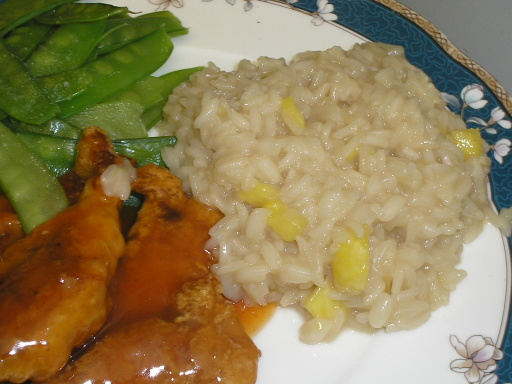

In [5]:
example = dataset["train"][0]
image = example["image"]
image

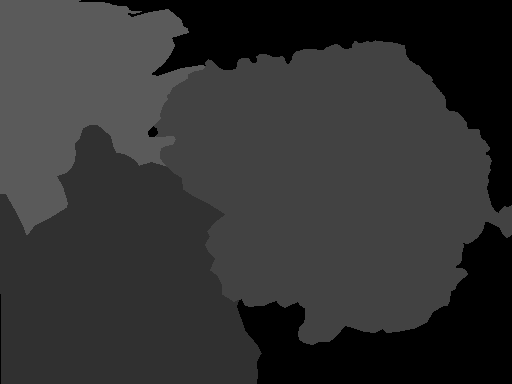

In [7]:
segmentation_map = example["label"]
segmentation_map

In case of semantic segmentation, every pixel is labeled with a certain class. 0 is the "background" class.

array([[90, 90, 90, ...,  0,  0,  0],
       [90, 90, 90, ...,  0,  0,  0],
       [90, 90, 90, ...,  0,  0,  0],
       ...,
       [ 0, 48, 48, ...,  0,  0,  0],
       [ 0, 48, 48, ...,  0,  0,  0],
       [ 0, 48, 48, ...,  0,  0,  0]], dtype=uint8)
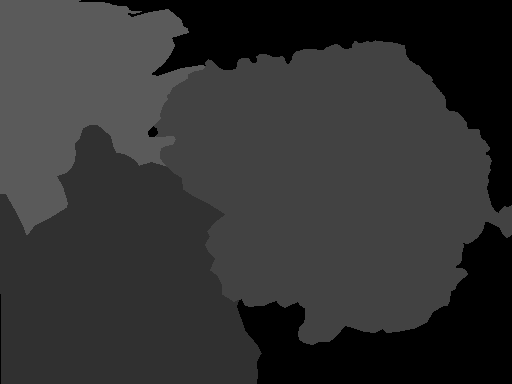

In [8]:
import numpy as np

segmentation_map = np.array(segmentation_map)
segmentation_map

Let's load the mappings between integers and their classes (I got that from the [dataset card](https://huggingface.co/datasets/EduardoPacheco/FoodSeg103#data-categories) and asked an LLM to turn it into a dictionary).

In [9]:
id2label = {
    0: "background",
    1: "candy",
    2: "egg tart",
    3: "french fries",
    4: "chocolate",
    5: "biscuit",
    6: "popcorn",
    7: "pudding",
    8: "ice cream",
    9: "cheese butter",
    10: "cake",
    11: "wine",
    12: "milkshake",
    13: "coffee",
    14: "juice",
    15: "milk",
    16: "tea",
    17: "almond",
    18: "red beans",
    19: "cashew",
    20: "dried cranberries",
    21: "soy",
    22: "walnut",
    23: "peanut",
    24: "egg",
    25: "apple",
    26: "date",
    27: "apricot",
    28: "avocado",
    29: "banana",
    30: "strawberry",
    31: "cherry",
    32: "blueberry",
    33: "raspberry",
    34: "mango",
    35: "olives",
    36: "peach",
    37: "lemon",
    38: "pear",
    39: "fig",
    40: "pineapple",
    41: "grape",
    42: "kiwi",
    43: "melon",
    44: "orange",
    45: "watermelon",
    46: "steak",
    47: "pork",
    48: "chicken duck",
    49: "sausage",
    50: "fried meat",
    51: "lamb",
    52: "sauce",
    53: "crab",
    54: "fish",
    55: "shellfish",
    56: "shrimp",
    57: "soup",
    58: "bread",
    59: "corn",
    60: "hamburg",
    61: "pizza",
    62: "hanamaki baozi",
    63: "wonton dumplings",
    64: "pasta",
    65: "noodles",
    66: "rice",
    67: "pie",
    68: "tofu",
    69: "eggplant",
    70: "potato",
    71: "garlic",
    72: "cauliflower",
    73: "tomato",
    74: "kelp",
    75: "seaweed",
    76: "spring onion",
    77: "rape",
    78: "ginger",
    79: "okra",
    80: "lettuce",
    81: "pumpkin",
    82: "cucumber",
    83: "white radish",
    84: "carrot",
    85: "asparagus",
    86: "bamboo shoots",
    87: "broccoli",
    88: "celery stick",
    89: "cilantro mint",
    90: "snow peas",
    91: "cabbage",
    92: "bean sprouts",
    93: "onion",
    94: "pepper",
    95: "green beans",
    96: "French beans",
    97: "king oyster mushroom",
    98: "shiitake",
    99: "enoki mushroom",
    100: "oyster mushroom",
    101: "white button mushroom",
    102: "salad",
    103: "other ingredients"
}

In [10]:
print(id2label)

{0: 'background', 1: 'candy', 2: 'egg tart', 3: 'french fries', 4: 'chocolate', 5: 'biscuit', 6: 'popcorn', 7: 'pudding', 8: 'ice cream', 9: 'cheese butter', 10: 'cake', 11: 'wine', 12: 'milkshake', 13: 'coffee', 14: 'juice', 15: 'milk', 16: 'tea', 17: 'almond', 18: 'red beans', 19: 'cashew', 20: 'dried cranberries', 21: 'soy', 22: 'walnut', 23: 'peanut', 24: 'egg', 25: 'apple', 26: 'date', 27: 'apricot', 28: 'avocado', 29: 'banana', 30: 'strawberry', 31: 'cherry', 32: 'blueberry', 33: 'raspberry', 34: 'mango', 35: 'olives', 36: 'peach', 37: 'lemon', 38: 'pear', 39: 'fig', 40: 'pineapple', 41: 'grape', 42: 'kiwi', 43: 'melon', 44: 'orange', 45: 'watermelon', 46: 'steak', 47: 'pork', 48: 'chicken duck', 49: 'sausage', 50: 'fried meat', 51: 'lamb', 52: 'sauce', 53: 'crab', 54: 'fish', 55: 'shellfish', 56: 'shrimp', 57: 'soup', 58: 'bread', 59: 'corn', 60: 'hamburg', 61: 'pizza', 62: 'hanamaki baozi', 63: 'wonton dumplings', 64: 'pasta', 65: 'noodles', 66: 'rice', 67: 'pie', 68: 'tofu', 6

We can visualize the segmentation map on top of the image, like so:

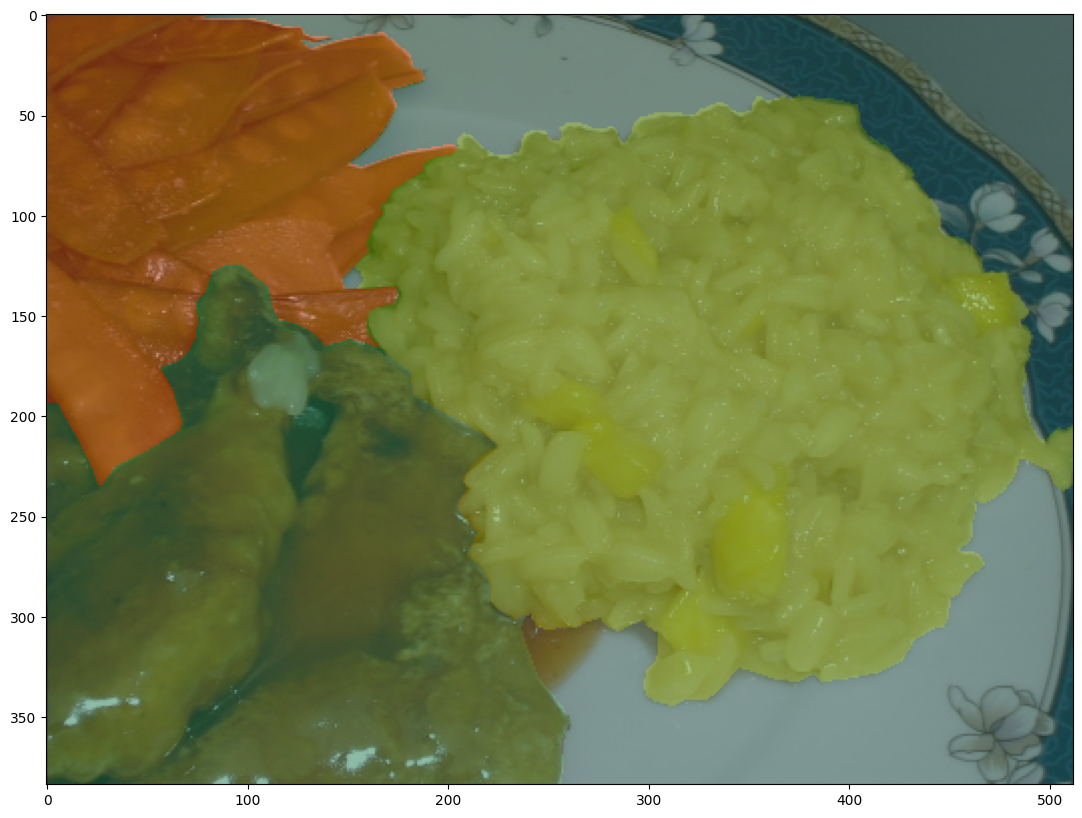

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# map every class to a random color
id2color = {k: list(np.random.choice(range(256), size=3)) for k,v in id2label.items()}

def visualize_map(image, segmentation_map):
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    for label, color in id2color.items():
        color_seg[segmentation_map == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

visualize_map(image, segmentation_map)

## Create PyTorch dataset

We create a regular PyTorch dataset, which prepares the examples for the model. We augment the training images by random resizing and cropping them to a fixed resolution (448x448), and normalize the color channels. This way, all our training images will have the same fixed resolution. Here we use the [Albumentations](https://albumentations.ai/) library for that purpose, but note that one can also use other libraries like Torchvision or Kornia.

 Note that the model will expect `pixel_values` of shape (batch_size, num_channels, height, width) as input. As Albumentations works on NumPy arrays (which uses a channels-last format), we make sure that the channels are first. The `labels` which the model also expects are of shape (batch_size, height, width) and indicate the ground truth label per pixel, for every example in the batch.

In [12]:
from torch.utils.data import Dataset
import torch

class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    original_image = np.array(item["image"])
    original_segmentation_map = np.array(item["label"])

    transformed = self.transform(image=original_image, mask=original_segmentation_map)
    image, target = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])

    # convert to C, H, W
    image = image.permute(2,0,1)

    return image, target, original_image, original_segmentation_map

Let's create the training and validation datasets (note that we only randomly crop for training images).

In [13]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    # hadded an issue with an image being too small to crop, PadIfNeeded didn't help...
    # if anyone knows why this is happening I'm happy to read why
    # A.PadIfNeeded(min_height=448, min_width=448),
    # A.RandomResizedCrop(height=448, width=448),
    A.Resize(width=448, height=448),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

val_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = SegmentationDataset(dataset["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset["validation"], transform=val_transform)

In [14]:
pixel_values, target, original_image, original_segmentation_map = train_dataset[3]
print(pixel_values.shape)
print(target.shape)

torch.Size([3, 448, 448])
torch.Size([448, 448])


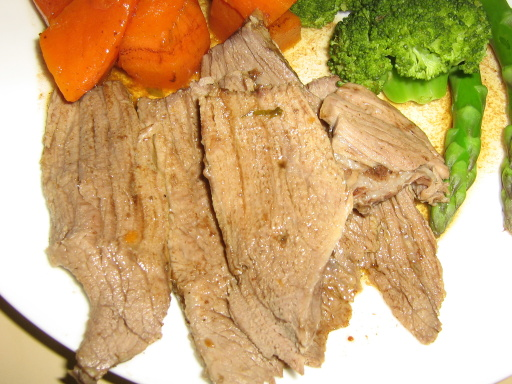

In [15]:
from PIL import Image

Image.fromarray(original_image)

In [16]:
[id2label[id] for id in np.unique(original_segmentation_map).tolist()]

['background', 'chicken duck', 'carrot', 'asparagus', 'broccoli']

## Create PyTorch dataloaders

Next, we create PyTorch dataloaders, which allow us to get batches of data (as neural networks are trained on batches using stochastic gradient descent or SGD). We just stack the various images and labels along a new batch dimension.

In [17]:
from torch.utils.data import DataLoader

def collate_fn(inputs):
    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["original_images"] = [i[2] for i in inputs]
    batch["original_segmentation_maps"] = [i[3] for i in inputs]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

Let's check a batch:

In [18]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([2, 3, 448, 448])
labels torch.Size([2, 448, 448])


Note that the pixel values are float32 tensors, whereas the labels are long tensors:

In [19]:
batch["pixel_values"].dtype

torch.float32

In [20]:
batch["labels"].dtype

torch.int64

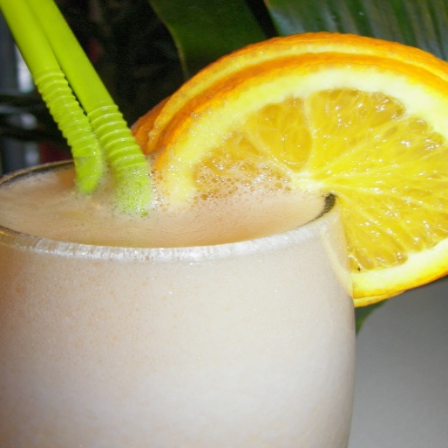

In [21]:
from PIL import Image

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = Image.fromarray(unnormalized_image)
unnormalized_image

In [22]:
[id2label[id] for id in torch.unique(batch["labels"][0]).tolist()]

['background', 'milkshake', 'orange']

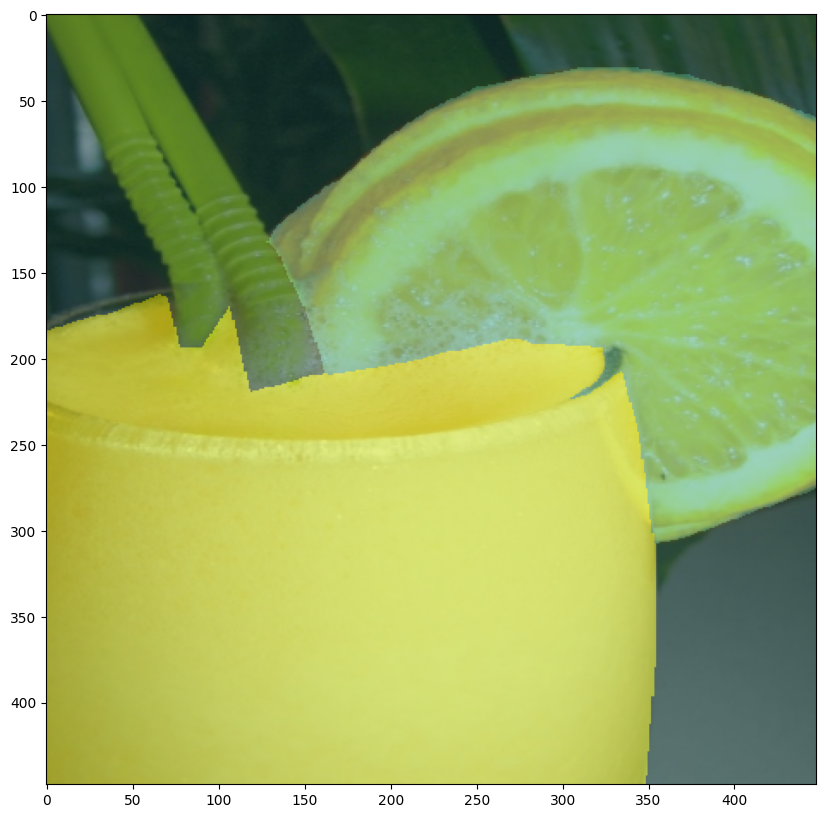

In [23]:
visualize_map(unnormalized_image, batch["labels"][0].numpy())

## Define model

Next, we define the model, which consists of DINOv2 as backbone + a linear classifier on top. DINOv2 is a regular vision transformer, hence it outputs "patch embeddings", meaning an embedding vector for each image patch. Since we use an image resolution of 448 pixels, and we use a DINOv2 model that has a patch resolution of 14 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L19), we get (448/14)**2 = 1024 patches out. So the model outputs a tensor of shape (batch_size, number of patches, hidden_size) = (batch_size, 1024, 768) for a batch of images (the model has a hidden size - also called embedding dimension - of 768 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L9)).

Next, we reshape this tensor to become (batch_size, 32, 32, 768), after which we apply the linear layer (below implemented as a Conv2D layer - which is equivalent to a linear transformation when you employ a kernel size of 1x1). This conv2D layer converts the patch embeddings into a logits tensor of shape (batch_size, num_labels, height, width) - which is what we need for semantic segmentation. This tensor contains scores as predicted by the model for all of the classes, for each pixel, for every example in the batch.

In [24]:
import torch
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput

class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)


class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.dinov2 = Dinov2Model(config)
    self.classifier = LinearClassifier(config.hidden_size, 32, 32, config.num_labels)

  def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
    outputs = self.dinov2(pixel_values,
                            output_hidden_states=output_hidden_states,
                            output_attentions=output_attentions)
    # get the patch embeddings - so we exclude the CLS token
    patch_embeddings = outputs.last_hidden_state[:,1:,:]

    # convert to logits and upsample to the size of the pixel values
    logits = self.classifier(patch_embeddings)
    logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

    loss = None
    if labels is not None:
      # important: we're going to use 0 here as ignore index instead of the default -100
      # as we don't want the model to learn to predict background
      loss_fct = torch.nn.CrossEntropyLoss(ignore_index=0)
      loss = loss_fct(logits.squeeze(), labels.squeeze())

    return SemanticSegmenterOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

We can instantiate the model as follows:

In [25]:
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=id2label, num_labels=len(id2label))

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Important: we don't want to train the DINOv2 backbone, only the linear classification head. Hence we don't want to track any gradients for the backbone parameters. This will greatly save us in terms of memory used:

In [26]:
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = False

Let's perform a forward pass on a random batch, to verify the shape of the logits, verify we can calculate a loss:

In [27]:
outputs = model(pixel_values=batch["pixel_values"], labels=batch["labels"])
print(outputs.logits.shape)
print(outputs.loss)

torch.Size([2, 104, 448, 448])
tensor(4.9412, grad_fn=<NllLoss2DBackward0>)


As can be seen, the logits are of shape (batch_size, num_labels, height, width). We can then just take the highest logit (score) for each pixel as the model's prediction.

## Train the model

We'll train the model in regular PyTorch fashion. We also use the mIoU (mean Intersection-over-Union) metric to evaluate the performance during training.

Note that I made this entire notebook just for demo purposes, I haven't done any hyperparameter tuning, so feel free to improve. You can also of course use other training frameworks (like the 🤗 Trainer, PyTorch Lightning, 🤗 Accelerate, ...).

In [28]:
import evaluate

metric = evaluate.load("mean_iou")

In [38]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch.nn.functional as F

# training hyperparameters
# NOTE: I've just put some random ones here, not optimized at all
# feel free to experiment, see also DINOv2 paper
learning_rate = 5e-5
epochs = 10

optimizer = AdamW(model.parameters(), lr=learning_rate)

# put model on GPU (set runtime to GPU in Google Colab)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# put model in training mode
model.train()

for epoch in range(epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(tqdm(train_dataloader)):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      # forward pass
      outputs = model(pixel_values)
      loss = F.cross_entropy(outputs.logits, labels)

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()

      # evaluate
      with torch.no_grad():
        predicted = outputs.logits.argmax(dim=1)

        # note that the metric expects predictions + labels as numpy arrays
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

      # let's print loss and metrics every 100 batches
      if idx % 100 == 0:
        metrics = metric.compute(num_labels=len(id2label),
                                ignore_index=0,
                                reduce_labels=False,
        )

        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 4.322827339172363
Mean_iou: 0.40735913596621903
Mean accuracy: 0.5311176225738996
Loss: 4.531774520874023
Mean_iou: 0.3919484473204283
Mean accuracy: 0.5196439070839
Loss: 2.451843023300171
Mean_iou: 0.38259716028304264
Mean accuracy: 0.5111398847451021
Loss: 2.1996288299560547
Mean_iou: 0.4108450599285334
Mean accuracy: 0.5348153322846767
Loss: 1.047266960144043
Mean_iou: 0.38739569324479306
Mean accuracy: 0.535955900320231
Loss: 1.9890758991241455
Mean_iou: 0.42188932924774847
Mean accuracy: 0.5428773456151241
Loss: 1.1159029006958008
Mean_iou: 0.3880041853935485
Mean accuracy: 0.5316014954389118
Loss: 0.7372679710388184
Mean_iou: 0.44068554100066104
Mean accuracy: 0.5756775272647592
Loss: 1.3488922119140625
Mean_iou: 0.39991429646411475
Mean accuracy: 0.5439735908232685
Loss: 1.0655015707015991
Mean_iou: 0.41029614316741164
Mean accuracy: 0.5376216256818114
Loss: 0.8978673219680786
Mean_iou: 0.406114957493118
Mean accuracy: 0.582107937070895
Loss: 0.7556795477867126
Mean_iou: 

  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 0.7180532217025757
Mean_iou: 0.3939725200322246
Mean accuracy: 0.5346960125364427
Loss: 0.5804492235183716
Mean_iou: 0.4369593471246278
Mean accuracy: 0.5785878630757433
Loss: 0.636329710483551
Mean_iou: 0.42417142267510344
Mean accuracy: 0.538774258985346
Loss: 0.9885454773902893
Mean_iou: 0.45574339888277815
Mean accuracy: 0.5744575697222365
Loss: 0.37153181433677673
Mean_iou: 0.4124831469072469
Mean accuracy: 0.5459997258298565
Loss: 1.1725740432739258
Mean_iou: 0.3930195979924647
Mean accuracy: 0.5148163870245523
Loss: 0.4202723503112793
Mean_iou: 0.44513459109039194
Mean accuracy: 0.561123812198454
Loss: 0.750720202922821
Mean_iou: 0.41511235342769814
Mean accuracy: 0.5326083890508369
Loss: 0.5479416251182556
Mean_iou: 0.4286230333731188
Mean accuracy: 0.573622019125853
Loss: 1.2220866680145264
Mean_iou: 0.4181041993531175
Mean accuracy: 0.5427405119675486
Loss: 0.3005991578102112
Mean_iou: 0.44048451680247513
Mean accuracy: 0.583414470886646
Loss: 0.42260491847991943
Mean_i

  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 0.6649688482284546
Mean_iou: 0.40736303637633914
Mean accuracy: 0.5515056136985507
Loss: 0.39041072130203247
Mean_iou: 0.4424872326140725
Mean accuracy: 0.6032548448506245
Loss: 0.5225054025650024
Mean_iou: 0.4591436059859275
Mean accuracy: 0.5893707711635727
Loss: 0.6710814833641052
Mean_iou: 0.4618701391414231
Mean accuracy: 0.6113551652841169
Loss: 0.6088865995407104
Mean_iou: 0.44354763696820837
Mean accuracy: 0.6029725926237688
Loss: 0.45285314321517944
Mean_iou: 0.40892209550046676
Mean accuracy: 0.5453214343659675
Loss: 1.3751018047332764
Mean_iou: 0.44362861708935164
Mean accuracy: 0.591623943929624
Loss: 0.3644733726978302
Mean_iou: 0.44513623918469647
Mean accuracy: 0.585306911249003
Loss: 0.3433054983615875
Mean_iou: 0.4091337261896649
Mean accuracy: 0.5574135772635052
Loss: 0.49339789152145386
Mean_iou: 0.4377921879778171
Mean accuracy: 0.5731139637317357
Loss: 0.4763118624687195
Mean_iou: 0.43352247224451296
Mean accuracy: 0.5607440586365982
Loss: 0.5083343982696533


  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 0.8256862163543701
Mean_iou: 0.4439363353764553
Mean accuracy: 0.6141485147198572
Loss: 0.4446832239627838
Mean_iou: 0.4701121824075203
Mean accuracy: 0.610130423778161
Loss: 0.7546347975730896
Mean_iou: 0.4562242124511212
Mean accuracy: 0.6114911320311308
Loss: 0.4199272394180298
Mean_iou: 0.4470321692179683
Mean accuracy: 0.6322060424034486
Loss: 0.41775068640708923
Mean_iou: 0.46667126255889085
Mean accuracy: 0.617013296809135
Loss: 0.3263894021511078
Mean_iou: 0.43830257182381116
Mean accuracy: 0.6033787586548323
Loss: 0.5296582579612732
Mean_iou: 0.45175746887622487
Mean accuracy: 0.5852016928528591
Loss: 0.5343382954597473
Mean_iou: 0.4383606742973455
Mean accuracy: 0.5913772336773394
Loss: 0.5474578142166138
Mean_iou: 0.484175026746804
Mean accuracy: 0.6236414321484055
Loss: 0.46731576323509216
Mean_iou: 0.4320321625669989
Mean accuracy: 0.5953123158657185
Loss: 0.6777953505516052
Mean_iou: 0.4983850512980016
Mean accuracy: 0.6345440564872193
Loss: 0.5148951411247253
Mean_

  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 0.6361875534057617
Mean_iou: 0.4335663785306833
Mean accuracy: 0.6239335254074723
Loss: 0.9039111137390137
Mean_iou: 0.43183137419975276
Mean accuracy: 0.560245891241997
Loss: 0.2522546350955963
Mean_iou: 0.46104427500331707
Mean accuracy: 0.6270932989926445
Loss: 0.3448345363140106
Mean_iou: 0.47591516265908557
Mean accuracy: 0.6268186262214969
Loss: 0.4391446113586426
Mean_iou: 0.4833103278543126
Mean accuracy: 0.6497307453562301
Loss: 1.961247205734253
Mean_iou: 0.4743716542930901
Mean accuracy: 0.6188760189971101
Loss: 0.703337550163269
Mean_iou: 0.4562950124446342
Mean accuracy: 0.572728828861214
Loss: 0.35697343945503235
Mean_iou: 0.46235197727956034
Mean accuracy: 0.6158577502103469
Loss: 0.2592107951641083
Mean_iou: 0.4541888997854805
Mean accuracy: 0.6222773300953912
Loss: 0.8695395588874817
Mean_iou: 0.44005480893872384
Mean accuracy: 0.6468811865338139
Loss: 0.5803757309913635
Mean_iou: 0.4994056479662624
Mean accuracy: 0.6206727594121891
Loss: 0.4935315251350403
Mean_

  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 0.6161839365959167
Mean_iou: 0.47148895326902357
Mean accuracy: 0.6397742776154195
Loss: 0.6719725728034973
Mean_iou: 0.4831002039734749
Mean accuracy: 0.624269121723016
Loss: 1.3145768642425537
Mean_iou: 0.4951686432972876
Mean accuracy: 0.6420075995037329
Loss: 0.3370654881000519
Mean_iou: 0.4686552282561245
Mean accuracy: 0.604173070412137
Loss: 0.5765897035598755
Mean_iou: 0.4615960313391109
Mean accuracy: 0.6589201381288984
Loss: 0.7070314288139343
Mean_iou: 0.4955996561053968
Mean accuracy: 0.6440493116730112
Loss: 0.32006826996803284
Mean_iou: 0.45805814547631263
Mean accuracy: 0.6263153506275472
Loss: 0.3956384062767029
Mean_iou: 0.4583260141973898
Mean accuracy: 0.5943925421163521
Loss: 0.37242910265922546
Mean_iou: 0.5041790382633762
Mean accuracy: 0.6349273760220973
Loss: 0.4885352849960327
Mean_iou: 0.5094896507069807
Mean accuracy: 0.6682719972161937
Loss: 0.737464189529419
Mean_iou: 0.4631372792322786
Mean accuracy: 0.6018692370771243
Loss: 0.3102946877479553
Mean_i

  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 0.575095534324646
Mean_iou: 0.4502688499210716
Mean accuracy: 0.6218208802505261
Loss: 1.5712456703186035
Mean_iou: 0.4870042149742749
Mean accuracy: 0.6580490829462228
Loss: 0.782520055770874
Mean_iou: 0.41757573422559385
Mean accuracy: 0.6271651764156092
Loss: 0.27879855036735535
Mean_iou: 0.5357692798883168
Mean accuracy: 0.6598398499315409
Loss: 0.4147748053073883
Mean_iou: 0.46308330510425383
Mean accuracy: 0.5978755316014535
Loss: 0.3626873195171356
Mean_iou: 0.46179294255967834
Mean accuracy: 0.6215066333158725
Loss: 0.606636106967926
Mean_iou: 0.5128816081848172
Mean accuracy: 0.674606806115602
Loss: 0.48970848321914673
Mean_iou: 0.491481580558477
Mean accuracy: 0.6288939280056237
Loss: 0.7830554246902466
Mean_iou: 0.4441748377220283
Mean accuracy: 0.6356570111553893
Loss: 0.974604070186615
Mean_iou: 0.47474205589532265
Mean accuracy: 0.6199950122495085
Loss: 0.5631464123725891
Mean_iou: 0.4890872197540401
Mean accuracy: 0.6602986364800348
Loss: 0.625156819820404
Mean_iou

  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 0.47951555252075195
Mean_iou: 0.47423570683014843
Mean accuracy: 0.6771318264370481
Loss: 0.4095761179924011
Mean_iou: 0.5154482045570907
Mean accuracy: 0.7028668502248357
Loss: 0.8199478983879089
Mean_iou: 0.4914186066719278
Mean accuracy: 0.6694141457436771
Loss: 0.6638215780258179
Mean_iou: 0.4849762405899821
Mean accuracy: 0.6202483733620058
Loss: 0.5458614826202393
Mean_iou: 0.4911979411145439
Mean accuracy: 0.6569300795656219
Loss: 0.6731860041618347
Mean_iou: 0.5106934000227403
Mean accuracy: 0.6645355733658622
Loss: 0.42376670241355896
Mean_iou: 0.4859436969205204
Mean accuracy: 0.6710871005954523
Loss: 0.4638802409172058
Mean_iou: 0.4455012365575523
Mean accuracy: 0.5915404161492624
Loss: 0.11861760169267654
Mean_iou: 0.4791710288106545
Mean accuracy: 0.6569810205025843
Loss: 0.6182253956794739
Mean_iou: 0.46725539982469666
Mean accuracy: 0.6172654157208937
Loss: 0.44698038697242737
Mean_iou: 0.4860101127368089
Mean accuracy: 0.6299326375161429
Loss: 0.9087831974029541
M

  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 0.7751080989837646
Mean_iou: 0.5203896688953714
Mean accuracy: 0.6781261071163973
Loss: 0.36428678035736084
Mean_iou: 0.5295118919415059
Mean accuracy: 0.6821048167369334
Loss: 0.37862473726272583
Mean_iou: 0.4561186873268706
Mean accuracy: 0.6207828962997999
Loss: 0.5910505056381226
Mean_iou: 0.5307298135971489
Mean accuracy: 0.6822634782822925
Loss: 0.384444922208786
Mean_iou: 0.49343626920276384
Mean accuracy: 0.6273693511731997
Loss: 0.432717889547348
Mean_iou: 0.4673631561102483
Mean accuracy: 0.6305715362087659
Loss: 0.5658401250839233
Mean_iou: 0.5135635917816551
Mean accuracy: 0.672254163998573
Loss: 0.4245811104774475
Mean_iou: 0.4937970642481461
Mean accuracy: 0.6844656566822221
Loss: 0.3565901219844818
Mean_iou: 0.47533974422696407
Mean accuracy: 0.6370017702144422
Loss: 0.397835910320282
Mean_iou: 0.5037400078300314
Mean accuracy: 0.6353466827774529
Loss: 0.6417653560638428
Mean_iou: 0.4888543616796864
Mean accuracy: 0.6473577539576804
Loss: 0.38004809617996216
Mean_i

  0%|          | 0/2492 [00:00<?, ?it/s]

Loss: 0.6094037890434265
Mean_iou: 0.46695360473917163
Mean accuracy: 0.6517996097458278
Loss: 0.6075658798217773
Mean_iou: 0.4636363482979084
Mean accuracy: 0.6330741937766875
Loss: 0.5149238109588623
Mean_iou: 0.5204558953320073
Mean accuracy: 0.671070682797379
Loss: 0.7238534688949585
Mean_iou: 0.5197774897450002
Mean accuracy: 0.6739708380289191
Loss: 0.18794125318527222
Mean_iou: 0.5166842253738307
Mean accuracy: 0.6871339960249349
Loss: 0.43446338176727295
Mean_iou: 0.5334101400139508
Mean accuracy: 0.7074724971883328
Loss: 0.4858338534832001
Mean_iou: 0.47405237754401613
Mean accuracy: 0.6508868671984732
Loss: 0.23825913667678833
Mean_iou: 0.5140135727160903
Mean accuracy: 0.6331782955532962
Loss: 0.35615274310112
Mean_iou: 0.4863783528357676
Mean accuracy: 0.633991486111715
Loss: 0.3972114324569702
Mean_iou: 0.5176816177023186
Mean accuracy: 0.6639403347169188
Loss: 0.18628443777561188
Mean_iou: 0.5282712585255482
Mean accuracy: 0.7009073473389867
Loss: 0.34390902519226074
Mean

## Inference

Once we've trained a model, we can perform inference on new images as follows:

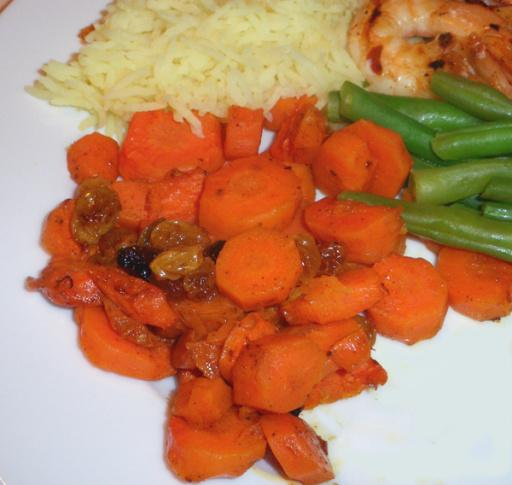

In [39]:
from PIL import Image

test_image = dataset["validation"][0]["image"]
test_image

In [40]:
pixel_values = val_transform(image=np.array(test_image))["image"]
pixel_values = torch.tensor(pixel_values)
pixel_values = pixel_values.permute(2,0,1).unsqueeze(0) # convert to (batch_size, num_channels, height, width)
print(pixel_values.shape)

torch.Size([1, 3, 448, 448])


In [45]:
# forward pass
with torch.no_grad():
  outputs = model(pixel_values.to(device))

In [46]:
upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=test_image.size[::-1],
                                                   mode="bilinear", align_corners=False)
predicted_map = upsampled_logits.argmax(dim=1)

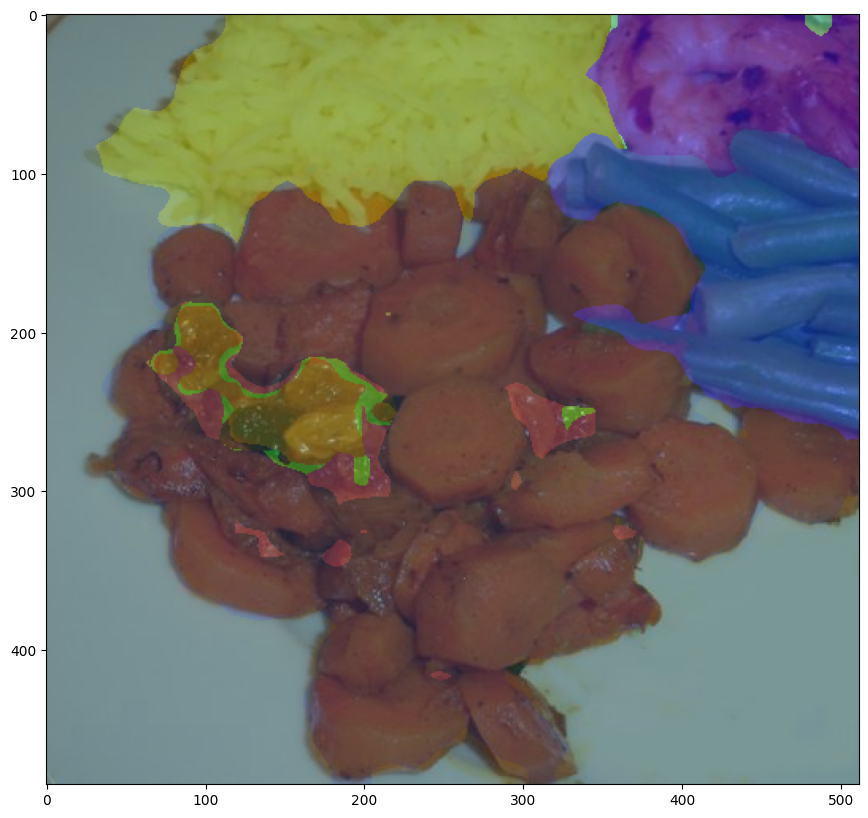

In [47]:
visualize_map(test_image, predicted_map.squeeze().cpu())

This is just an illustrative example (I barely trained the model) but you can clearly see that training is working :) the model is able to segment the rice and sausages properly already on an unseen image.